In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
customer = pd.read_csv(r'C:\Users\Admin\Brazilian Ecommerce\olist_customers_dataset.csv')
geo = pd.read_csv(r'C:\Users\Admin\Brazilian Ecommerce\olist_geolocation_dataset.csv')
item = pd.read_csv(r'C:\Users\Admin\Brazilian Ecommerce\olist_order_items_dataset.csv')
payment = pd.read_csv(r'C:\Users\Admin\Brazilian Ecommerce\olist_order_payments_dataset.csv')
review = pd.read_csv(r'C:\Users\Admin\Brazilian Ecommerce\olist_order_reviews_dataset.csv')
order = pd.read_csv(r'C:\Users\Admin\Brazilian Ecommerce\olist_orders_dataset.csv')
product_list = pd.read_csv(r'C:\Users\Admin\Brazilian Ecommerce\olist_products_dataset.csv')
seller = pd.read_csv(r'C:\Users\Admin\Brazilian Ecommerce\olist_sellers_dataset.csv')
product_category = pd.read_csv(r'C:\Users\Admin\Brazilian Ecommerce\product_category_name_translation.csv')
MQL = pd.read_csv(r'C:\Users\Admin\Brazilian Ecommerce\olist_marketing_qualified_leads_dataset.csv')
closed_deals = pd.read_csv(r'C:\Users\Admin\Brazilian Ecommerce\olist_closed_deals_dataset.csv')

In [3]:
list_of_df = [customer,
              geo,
              item,
              payment,
              review,
              order,
              product_list,
              seller,
              product_category,
              closed_deals,
              MQL]

for df in list_of_df:
    print(list(df.columns), len(df.columns))

['customer_id', 'customer_unique_id', 'customer_zip_code_prefix', 'customer_city', 'customer_state'] 5
['geolocation_zip_code_prefix', 'geolocation_lat', 'geolocation_lng', 'geolocation_city', 'geolocation_state'] 5
['order_id', 'order_item_id', 'product_id', 'seller_id', 'shipping_limit_date', 'price', 'freight_value'] 7
['order_id', 'payment_sequential', 'payment_type', 'payment_installments', 'payment_value'] 5
['review_id', 'order_id', 'review_score', 'review_comment_title', 'review_comment_message', 'review_creation_date', 'review_answer_timestamp'] 7
['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date', 'order_delivered_customer_date', 'order_estimated_delivery_date'] 8
['product_id', 'product_category_name', 'product_name_lenght', 'product_description_lenght', 'product_photos_qty', 'product_weight_g', 'product_length_cm', 'product_height_cm', 'product_width_cm'] 9
['seller_id', 'seller_zip_code_prefix', 'sell

# 1. RFM ANALYSIS

## 1.1. RECENCY

In [6]:
# getting the latest day of purchase for each user
recency_table = customer.merge(order, on ="customer_id")
recency_table = recency_table.groupby('customer_unique_id').agg({'order_purchase_timestamp': 'max'}).reset_index()
# convert to datetime dtype
recency_table['order_purchase_timestamp'] = pd.to_datetime(recency_table['order_purchase_timestamp'])
# calculate the current day 
current_day = pd.to_datetime(max(order['order_purchase_timestamp']))
# calculate the days between
recency_table['days_between'] = (current_day - recency_table['order_purchase_timestamp']).apply(lambda x: int(str(x).split()[0]))
# def function that scores the data
def scoring(x):
    # calculate quantiles
    quan_val_list = []
    for quan in [0.2,0.4,0.6,0.8]:
        quan_val_list.append(np.quantile(x,quan))
    # label the data base on the quantile value
    def labeling(x):
        if x < quan_val_list[0]: return 1
        elif x < quan_val_list[1]: return 2
        elif x < quan_val_list[2]: return 3
        elif x < quan_val_list[3]: return 4
        else: return 5

    return x.apply(labeling)

recency_table['recency_score'] = scoring(recency_table['days_between'])
recency_table

,customer_unique_id,order_purchase_timestamp,days_between,recency_score
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05-10 10:56:27,160,2
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05-07 11:11:27,163,2
2,0000f46a3911fa3c0805444483337064,2017-03-10 21:05:03,585,5
3,0000f6ccb0745a6a4b88665a16c9f078,2017-10-12 20:29:41,369,4
4,0004aac84e0df4da2b147fca70cf8255,2017-11-14 19:45:42,336,4
...,...,...,...,...
96091,fffcf5a5ff07b0908bd4e2dbc735a684,2017-06-08 21:00:36,495,5
96092,fffea47cd6d3cc0a88bd621562a9d061,2017-12-10 20:07:56,310,3
96093,ffff371b4d645b6ecea244b27531430a,2017-02-07 15:49:16,617,5
96094,ffff5962728ec6157033ef9805bacc48,2018-05-02 15:17:41,168,2


## 1.2. FREQUENCY

In [5]:
# merging df
frequency_table = customer.merge(order, on="customer_id")
# getting interested information
frequency_table = frequency_table.groupby('customer_unique_id').agg({
    "order_purchase_timestamp": ['min', 'max'],
    "order_id": 'count'
}).reset_index()
# change columns
frequency_table.columns = ['customer_unique_id', 'min', 'max', 'count']
# change data type
frequency_table['max'] = pd.to_datetime(frequency_table['max'])
frequency_table['min'] = pd.to_datetime(frequency_table['min'])
# days between first and last day of purchase 
frequency_table['days_between'] = (frequency_table['max'] - frequency_table['min']).apply(lambda x: int(str(x).split()[0]))
frequency_table['days_between'].value_counts()
# get rid of one-time-purchase customer
frequency_table = frequency_table[frequency_table['days_between']>0]
# calculate purchase_rate
frequency_table['purchase_rate'] = frequency_table['count'] / frequency_table['days_between']
# score the purchase_rate
frequency_table['frequency_score'] = scoring(frequency_table['purchase_rate'])

## 1.3. MONETARY

In [6]:
monetary_table = payment.merge(order, on="order_id").merge(customer, on="customer_id")
monetary_table = monetary_table.groupby('customer_unique_id').agg({'payment_value':'sum'}).reset_index()
monetary_table['monetary_score'] = scoring(monetary_table['payment_value'])
monetary_table

,customer_unique_id,payment_value,monetary_score
0,0000366f3b9a7992bf8c76cfdf3221e2,141.90,4
1,0000b849f77a49e4a4ce2b2a4ca5be3f,27.19,1
2,0000f46a3911fa3c0805444483337064,86.22,2
3,0000f6ccb0745a6a4b88665a16c9f078,43.62,1
4,0004aac84e0df4da2b147fca70cf8255,196.89,4
...,...,...,...
96090,fffcf5a5ff07b0908bd4e2dbc735a684,2067.42,5
96091,fffea47cd6d3cc0a88bd621562a9d061,84.58,2
96092,ffff371b4d645b6ecea244b27531430a,112.46,3
96093,ffff5962728ec6157033ef9805bacc48,133.69,4


## 1.4 COMBINE ALL TOGETHER

In [22]:
final_table = recency_table.merge(monetary_table, on = 'customer_unique_id').merge(frequency_table, on='customer_unique_id')
final_table = final_table[['customer_unique_id', "recency_score", "frequency_score","monetary_score"]]
final_table['frequency_monetary_score'] = scoring(final_table['frequency_score'] + final_table['monetary_score'])
final_table = final_table[['customer_unique_id', 'recency_score', 'frequency_monetary_score']]

segment_dict = {# hibernating
(1,1):"hibernating",
(1,2):"hibernating",
(2,1):"hibernating",
(2,2):"hibernating",
# about to sleep
(3,1):"about to sleep",
(3,2):"about to sleep",
# promising
(4,1):"promising",
# new customer
(5,1):"new customer",
# potential customers
(4,2):"potential",
(4,3):"potential",
(5,2):"potential",
(5,3):"potential",
# need attion
(3,3):"need attion",
# at risk
(1,3):"at risk",
(1,4):"at risk",
(2,3):"at risk",
(2,4):"at risk",
# do not lose
(1,5):"do not lose",
(2,5):"do not lose",
# loyal customer
(3,4):"loyal",
(3,5):"loyal",
(4,4):"loyal",
(4,5):"loyal",
# champions
(5,4):"champions",
(5,5):"champions"}

final_table['segment'] = final_table.apply(lambda x:
                  segment_dict[(x['recency_score'],x['frequency_monetary_score'])]
                  , axis = 1
                  )

In [23]:
final_data = final_table['segment'].value_counts()

<BarContainer object of 10 artists>

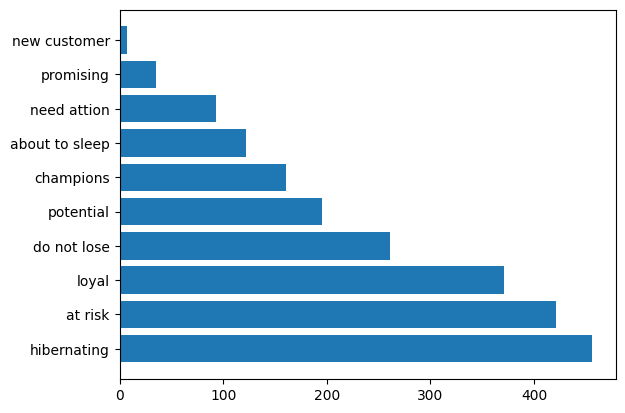

In [24]:
import matplotlib.pyplot as plt 

fig, ax = plt.subplots()
ax.barh(
    y =  final_data.index, 
    width =  final_data.values
)

# PRODUCTS THAT ARE FREQUENTLY BOUGHT TOGETHER

In [15]:
product_frequency_table = order.merge(item, on="order_id")[['order_id','product_id']]

In [16]:
list_of_item_list = []
for order, remaining_df in product_frequency_table.groupby('order_id'):
    list_of_item_list.append(list(remaining_df.drop_duplicates(subset='product_id')['product_id'].values))
list_of_item_list = [list_of_item for list_of_item in list_of_item_list if len(list_of_item) > 1]

In [17]:
from itertools import combinations

com_dict = {}
for list_of_item in list_of_item_list:
    for com in combinations(list_of_item,2):
        if com in com_dict: com_dict[com] +=1
        else: com_dict[com] = 1

res_df = pd.DataFrame(pd.Series(com_dict)).reset_index().rename(columns={'level_0':'item_1', "level_1": "item_2", 0: "count"}).sort_values('count',ascending=False)
top10 = res_df[:10]
top10

,item_1,item_2,count
110,e53e557d5a159f5aa2c5e995dfdf244b,36f60d45225e60c7da4558b070ce4b60,20
740,35afc973633aaeb6b877ff57b2793310,99a4788cb24856965c36a24e339b6058,15
200,36f60d45225e60c7da4558b070ce4b60,e53e557d5a159f5aa2c5e995dfdf244b,14
1552,99a4788cb24856965c36a24e339b6058,35afc973633aaeb6b877ff57b2793310,14
443,f4f67ccaece962d013a4e1d7dc3a61f7,4fcb3d9a5f4871e8362dfedbdb02b064,11
278,422879e10f46682990de24d770e7f83d,389d119b48cf3043d311335e499d9c6b,9
1010,3f14d740544f37ece8a9e7bc8349797e,36f60d45225e60c7da4558b070ce4b60,8
114,4fcb3d9a5f4871e8362dfedbdb02b064,f4f67ccaece962d013a4e1d7dc3a61f7,6
1021,422879e10f46682990de24d770e7f83d,53759a2ecddad2bb87a079a1f1519f73,5
1018,389d119b48cf3043d311335e499d9c6b,53759a2ecddad2bb87a079a1f1519f73,5


## From which channels did the leads come from? (percentage)

In [18]:
data = MQL['origin'].value_counts()
data

origin
organic_search       2296
paid_search          1586
social               1350
unknown              1099
direct_traffic        499
email                 493
referral              284
other                 150
display               118
other_publicities      65
Name: count, dtype: int64

Text(0.5, 1.0, 'CHANNEL DISTRIBUTION')

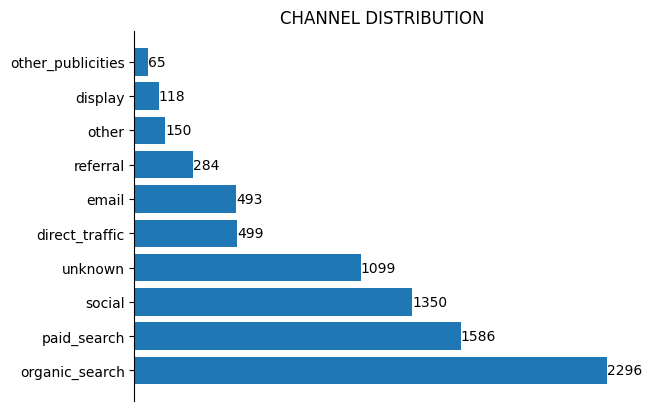

In [19]:
fig, ax = plt.subplots()
ax.barh(
    y = data.index,
    width = data.values
)

for index, value in data.items():
    ax.annotate(
        text = value,
        xy = (value, index),
        va = 'center'
    )

for spine in ['top', 'right', 'bottom']:
    ax.spines[spine].set_visible(False)

ax.set_xticklabels([])
ax.set_xticks([])
ax.set_title("CHANNEL DISTRIBUTION")

In [20]:
data = MQL.groupby('origin').agg({'mql_id': "count"}).reset_index().sort_values('mql_id',ascending=False)
data['percentage'] = data['mql_id'].apply(lambda x:
                     str(x/sum(data['mql_id']) * 100)[:5] + " %"
                     )
data

,origin,mql_id,percentage
3,organic_search,2296,28.91 %
6,paid_search,1586,19.97 %
8,social,1350,17.00 %
9,unknown,1099,13.84 %
0,direct_traffic,499,6.284 %
2,email,493,6.209 %
7,referral,284,3.576 %
4,other,150,1.889 %
1,display,118,1.486 %
5,other_publicities,65,0.818 %


## Find the products that usually appear in the positvely reviewed / negatively reviewed order


In [21]:
# merge 3 df
satis_table = review.merge(order, on = 'order_id').merge(item, on ='order_id')
# labeling customer review score
satis_table['satisfaction'] = satis_table['review_score'].apply(lambda x:
                                  "negative_order" if x < 3
                                  else(
                                       "positive_order" if x > 3
                                       else "neutral"
                                  )                           
                                  )
# group by the product - satisfaction, get the count of occurrence
satis_table = satis_table.groupby(['product_id','satisfaction']).agg({'order_id':'count'}).reset_index().sort_values('order_id',ascending=False)
# get top 10 positive products, top 10 negative products
top_10_pos = satis_table[satis_table['satisfaction'] == 'positive_order'][:10]
top_10_neg = satis_table[satis_table['satisfaction'] == 'negative_order'][:10]

TypeError: Can only merge Series or DataFrame objects, a <class 'str'> was passed

## Check for the seasonality 

In [ ]:
order['order_purchase_timestamp'] = pd.to_datetime(order['order_purchase_timestamp'])
# get the month 'order_purchase_timestamp'
order['month'] = order['order_purchase_timestamp'].dt.strftime("%m")
# merge with payment
seasonality_table = order.merge(payment, on='order_id')
# groupby month, get sum payment_value
seasonality_table = seasonality_table.groupby('month').agg({'payment_value':'mean'}).reset_index()


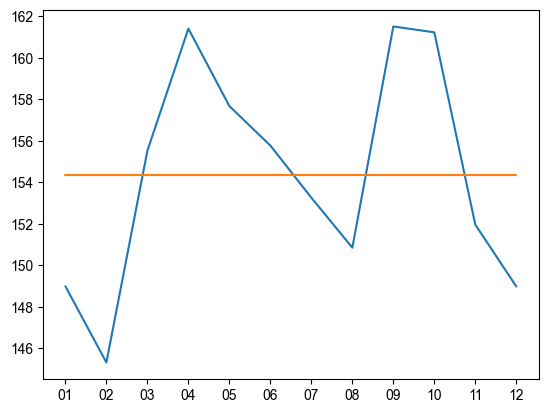

In [ ]:
# visualize the data
fig, ax = plt.subplots()
sns.set_theme(style='dark')

ax.plot(
    seasonality_table['month'],
    seasonality_table['payment_value']
)

ax.plot(
    seasonality_table['month'],
    [seasonality_table['payment_value'].mean()] * 12
)
